In [46]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [47]:
DATA_ROOT = Path('gesture_250302024')

In [48]:
tmp_ds = ImageFolder(DATA_ROOT)
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['L', 'OK', 'first', 'palm', 'peace']

In [49]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([224, 224]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([224, 224]),
                        tt.ToTensor(),
                        ])
     

In [50]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as tt
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np

# Assuming DATA_ROOT and CLASSES_NAME are defined as before
DATA_ROOT = 'gesture_250302024'
CLASSES_NAME = ['L', 'OK', 'first', 'palm', 'peace']

# Load the dataset
tmp_ds = ImageFolder(DATA_ROOT)

# Adjusted transforms without ToTensor(), and excluding random transformations for test set
train_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([224, 224]),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
    # Assuming we're converting back to PIL Image for saving
])

test_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([224, 224]),
    # Assuming we're converting back to PIL Image for saving
])

def save_transformed_images(dataset, indices, transform, save_dir_base):
    for idx in indices:
        image, label = dataset[idx]
        # Apply the transformation
        transformed_image = transform(image)

        # Create a directory for each class if it doesn't exist
        class_name = CLASSES_NAME[label]
        save_dir = os.path.join(save_dir_base, class_name)
        os.makedirs(save_dir, exist_ok=True)

        # Save the image
        save_path = os.path.join(save_dir, f"{idx}.png")
        transformed_image.save(save_path)

# Split dataset indices into train and test
indices = np.arange(len(tmp_ds))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Paths to save the transformed images
train_save_path = 'datasets/train'
test_save_path = 'datasets/test'

# Apply transformations and save
save_transformed_images(tmp_ds, train_indices, train_tfms_save, train_save_path)
save_transformed_images(tmp_ds, test_indices, test_tfms_save, test_save_path)

In [ ]:
LEN_DS = len(train_ds)
LEN_DS

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras import models, layers
from keras.optimizers import Adam
import cv2
from keras.callbacks import ModelCheckpoint
import random

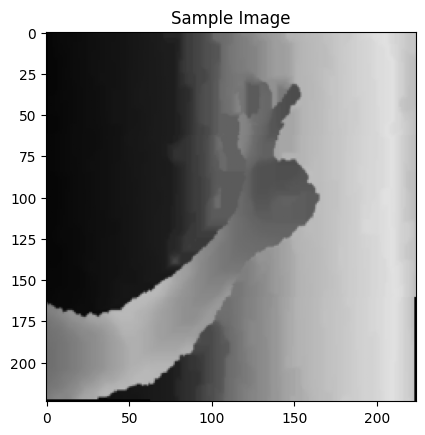

In [52]:

# Sample Image
image_path = 'datasets/train/OK/200.png'
img = mpimg.imread(image_path)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.show()

In [53]:
img.shape

(224, 224, 3)

In [54]:
train_dir = 'datasets/train'
test_dir = 'datasets/test'

In [55]:

train_data = []
test_data = []

def get_data(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.png'):
                image_path = os.path.join(label_dir, filename)
                data.append({'label': label, 'path': image_path})
    return data

In [56]:
train_df = pd.DataFrame(get_data(train_dir))
test_df = pd.DataFrame(get_data(test_dir))

In [20]:
train_df.head()

,label,path
0,first,datasets/train\first\400.png
1,first,datasets/train\first\401.png
2,first,datasets/train\first\402.png
3,first,datasets/train\first\403.png
4,first,datasets/train\first\404.png


In [57]:
train_df['label'].unique()

array(['first', 'L', 'OK', 'palm', 'peace'], dtype=object)

In [58]:
train_df.shape

(800, 2)

In [59]:
test_df.head()

,label,path
0,first,datasets/test\first\408.png
1,first,datasets/test\first\411.png
2,first,datasets/test\first\425.png
3,first,datasets/test\first\429.png
4,first,datasets/test\first\432.png


In [60]:
test_df['label'].unique()

array(['first', 'L', 'OK', 'palm', 'peace'], dtype=object)

In [61]:
img_width, img_height = 224, 224
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(train_df[y_col].unique())

In [62]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  "datasets/train",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")
     

Found 800 files belonging to 5 classes.


In [63]:

val_ds = tf.keras.utils.image_dataset_from_directory(
  "datasets/test",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 200 files belonging to 5 classes.


In [64]:

# Immutable base model
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False

In [73]:

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01),activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
# dense_layer_2 = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),activation='relu')
# dense_layer_3 = layers.Dense(264, kernel_regularizer=regularizers.l2(0.01),activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    # dense_layer_2,
    # dense_layer_3,
    prediction_layer
])

In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [75]:
classes = 5
epochs = 15
learning_rate = 0.0001

adam = Adam(learning_rate=learning_rate)

In [76]:

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds,shuffle=True)

Epoch 1/15


7/7 [==============================] - 53s 7s/step - loss: 18.7209 - accuracy: 0.3512 - val_loss: 10.3974 - val_accuracy: 0.8600
Epoch 2/15
7/7 [==============================] - 52s 7s/step - loss: 12.3569 - accuracy: 0.7050 - val_loss: 9.8985 - val_accuracy: 0.8600
Epoch 3/15
7/7 [==============================] - 52s 7s/step - loss: 10.2628 - accuracy: 0.8100 - val_loss: 9.5913 - val_accuracy: 0.8900
Epoch 4/15
7/7 [==============================] - 52s 7s/step - loss: 9.2038 - accuracy: 0.9075 - val_loss: 9.5506 - val_accuracy: 0.8700
Epoch 5/15
7/7 [==============================] - 51s 7s/step - loss: 8.7206 - accuracy: 0.9225 - val_loss: 9.0304 - val_accuracy: 0.9050
Epoch 6/15
7/7 [==============================] - 51s 7s/step - loss: 8.3687 - accuracy: 0.9450 - val_loss: 8.8215 - val_accuracy: 0.8800
Epoch 7/15
7/7 [==============================] - 51s 7s/step - loss: 8.0180 - accuracy: 0.9563 - val_loss: 8.6214 - val_accuracy: 0.8750
Epoch 8/15
7/7 [============

In [78]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [79]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

2/2 [==============================] - 11s 4s/step - loss: 7.3061 - accuracy: 0.8700
Test Loss: 7.3060688972473145, Test Accuracy: 87.00000047683716%


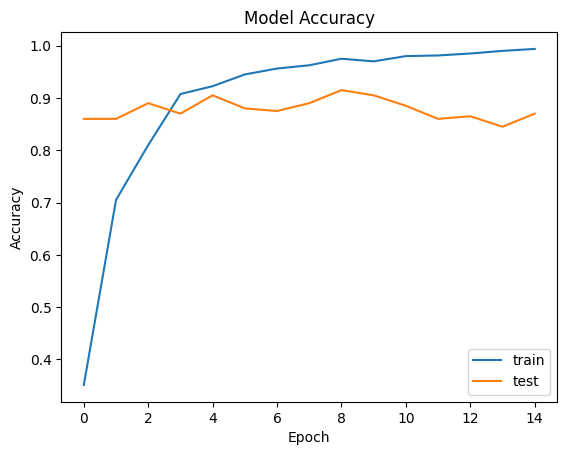

In [80]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [93]:
img = cv2.imread("datasets/test/OK/208.png")
img = np.expand_dims(img, 0)
     

In [94]:
pred = model.predict(img)

1/1 [==============================] - 0s 93ms/step


In [89]:


train_ds.class_names[np.argmax(pred[0])]

'palm'

In [90]:

model.save('modelvgg.h5')

C:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 92ms/step


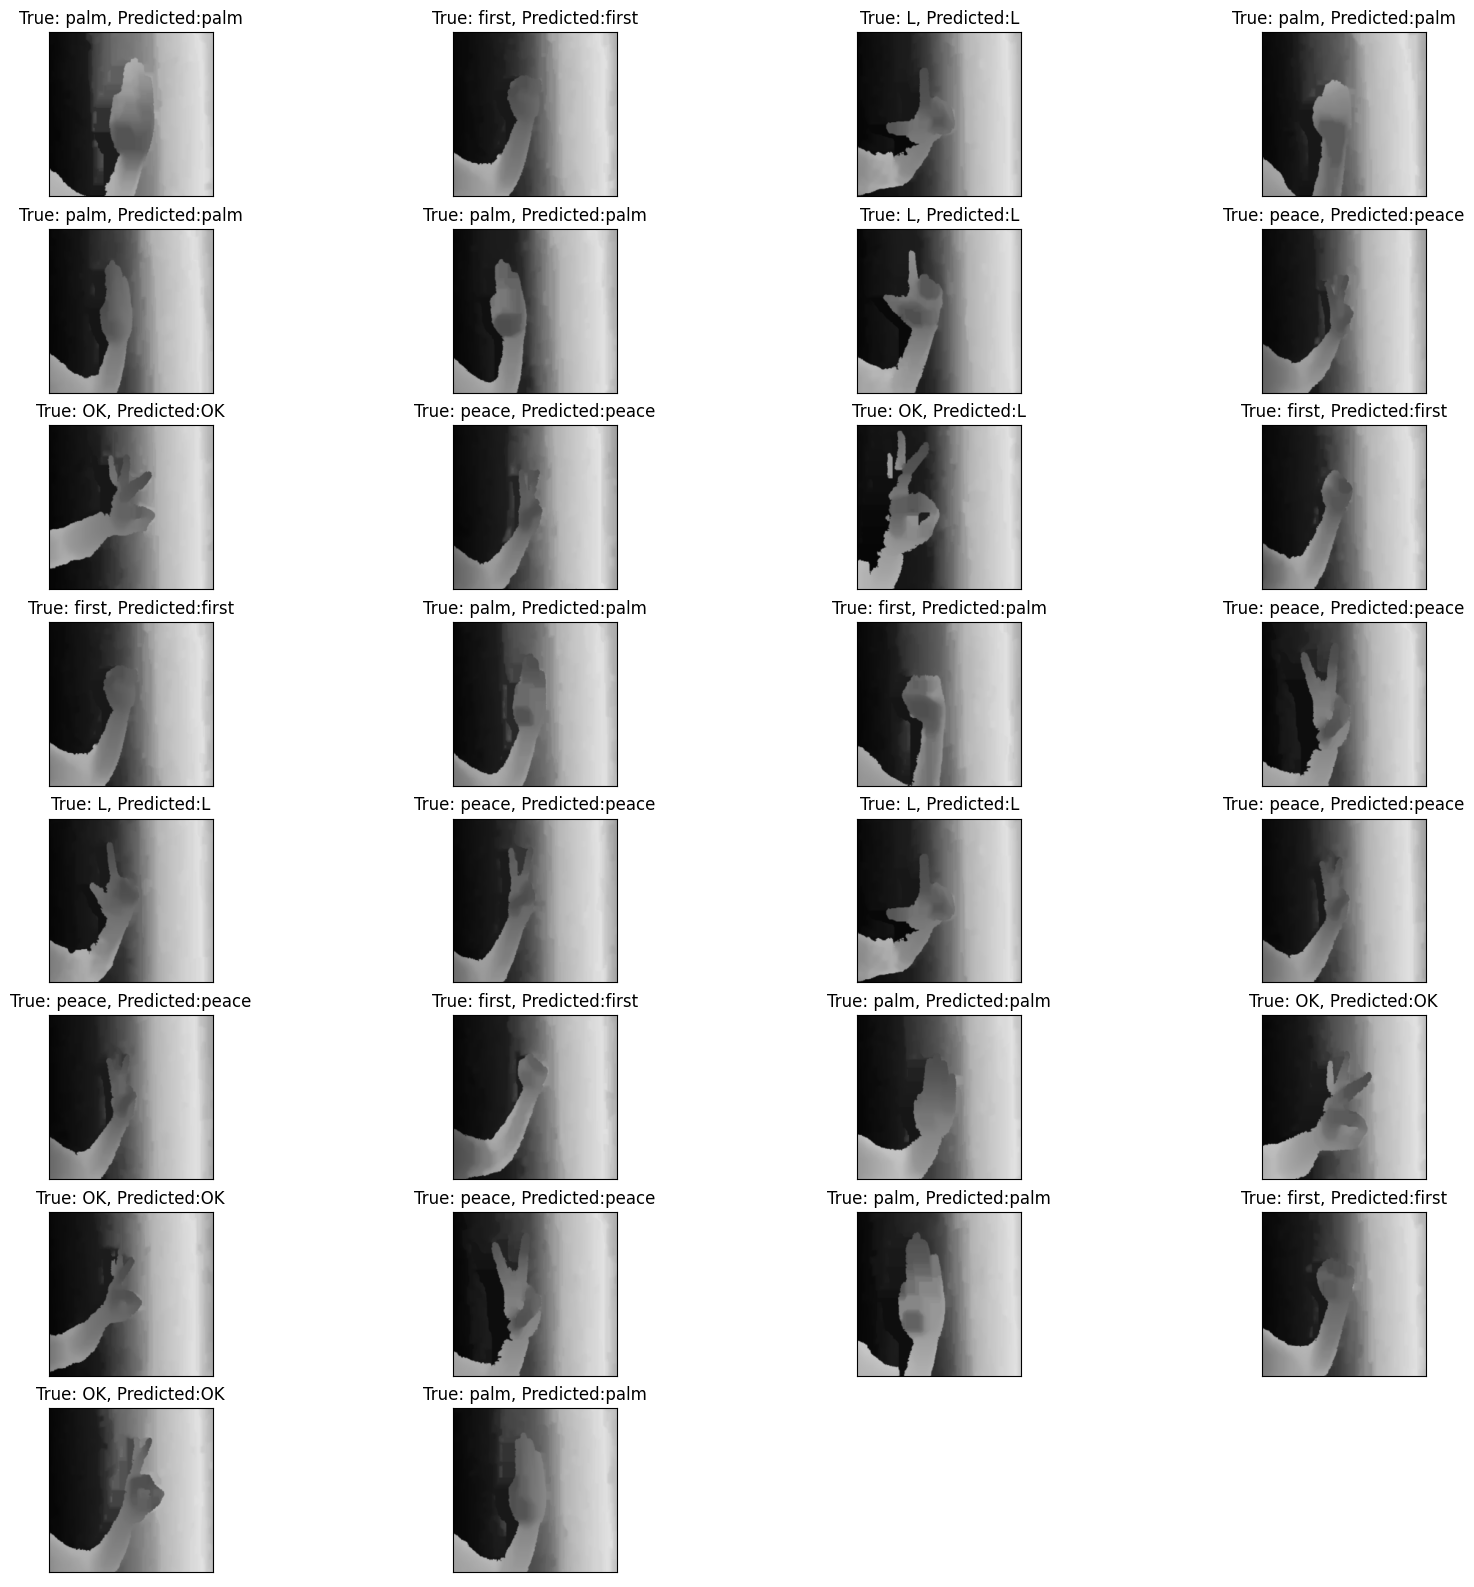

In [95]:

prefix = "datasets/test"

classes = os.listdir(prefix)

choices = []

for i in range(6):
  temp = {}
  for j in range(5):
    ch = random.choice(classes)
    li = os.listdir(prefix+"/"+ch)
    file_ = prefix+"/"+ch+"/"+random.choice(li)
    temp[file_] = ch
  choices.append(temp)

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20, 20))
n = 4
im = 8
ct = 1
for row in choices:
  for i in row:
    ax = plt.subplot(im, n, ct)
    ct = ct + 1
    image =  cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    image = np.expand_dims(image, 0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("True: {}, Predicted:{}".format(row[i], train_ds.class_names[np.argmax(model.predict(image)[0])]))
plt.show()
     

In [96]:

from tensorflow import keras
model = keras.models.load_model('modelvgg.h5')

1/1 [==============================] - 0s 88ms/step


'L'

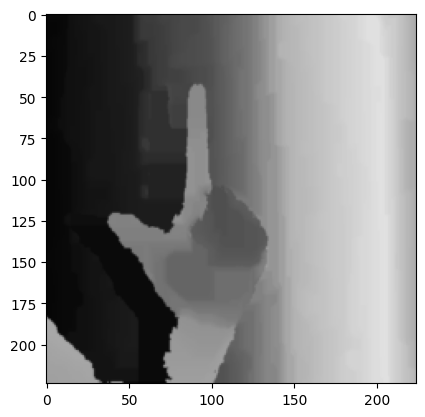

In [100]:

img = cv2.imread("datasets/test/L/174.png")
import matplotlib.pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = np.expand_dims(img, 0)
pred = model.predict(img)
train_ds.class_names[np.argmax(pred[0])]

1/1 [==============================] - 0s 93ms/step


'first'

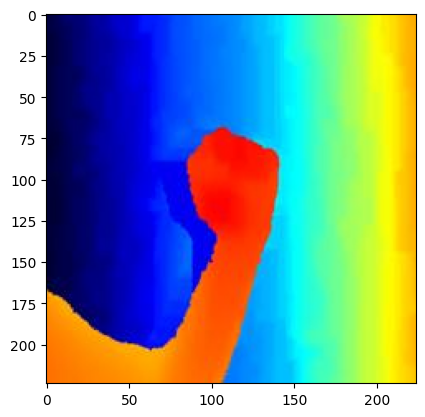

In [103]:
img = cv2.imread("image_1.jpg")
import matplotlib.pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = np.expand_dims(img, 0)
pred = model.predict(img)
train_ds.class_names[np.argmax(pred[0])]